# Задача 6. Компьютерное зрение: задача сегментации

**Автор**: Зиннатулин Тимур Раифович

**Группа**: 22.М04

## Задание

Выполненные пункты:
- Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику jaccard index. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для jaccard index, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.

- Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.

- Попробовать улучшить качество изменяя архитектуру.

## Датасет

В задаче используется датасет, указанный в условии. Доступен по ссылке: https://drive.google.com/file/d/11wp4Bm-hEVwmZq8GmqbLpKpJiqvDSNAe/view. В датасете есть набор изображений людей и набор масок.

## Подключение библиотек

Подключим используемые библиотеки:

In [1]:
import random

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch

# устанавливаем точность чисел с плавающей точкой
%precision %.4f

import warnings
warnings.filterwarnings('ignore')  # отключаем предупреждения

Зафиксируем сиды для воспроизведения результатов:

In [2]:
def set_seeds(initializer = 335):
    random.seed(initializer)
    torch.manual_seed(initializer)
    
set_seeds()

## Подготовка данных

Подключим Google Drive к Google Colab

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Распакуем архив с датасетом, который находится в корне Google Drive:

In [4]:
!unzip gdrive/My\ Drive/dataset.zip &> /dev/null

## Train/Test split

Считаем список путей изображений в папке **dataset/images/**:

In [5]:
from glob import glob

IMAGES_FOLDER_PATH = "./dataset/images"

imgs_list = glob(f"{IMAGES_FOLDER_PATH}/*")
print(f"Images list length: {len(imgs_list)}")

Images list length: 2000


Заведём класс для хранения изображений и их масок.

In [6]:
from torch.utils.data import Dataset
import numpy as np
import torch
import torchvision
from torchvision import io
import cv2

class SelfieDataset(Dataset):
    def __init__(self, imgs_list, transform = lambda id: id):
        self.imgs = imgs_list
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def get_mask_path(self, img_path):
        mask_path = img_path.split("/")
        mask_path[-2] = mask_path[-2].replace("images", "masks")
        mask_path[-1] = mask_path[-1][:-4] + ".png"
        mask_path = "/".join(mask_path)
        return mask_path

    def resize_image(self, img):
        return torchvision.transforms.Resize((256, 256))(img)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = self.resize_image(io.read_image(img_path))
        img = self.transform(img / 255)
        
        mask_path = self.get_mask_path(img_path)
        mask = self.resize_image(io.read_image(mask_path))
        mask = self.transform(mask / 255)

        return img, mask

Заведём test и train выборки:

In [7]:
train_dataset = SelfieDataset(imgs_list[:-300])
test_dataset = SelfieDataset(imgs_list[-300:])

print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 1700
Test dataset length: 300


Заведём функцию для отображения изображения из SelfieDataset:

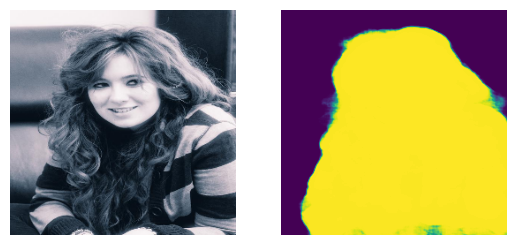

In [8]:
from torchvision.transforms import functional

def show_selfie(image, mask, is_mask_shown=True):
    _, (ax_l, ax_r) = plt.subplots(ncols=2)
    ax_l.imshow(functional.to_pil_image(image))
    ax_l.axis("off")
    ax_r.imshow(functional.to_pil_image(mask))
    ax_r.axis("off")

image, mask = train_dataset[0]
show_selfie(image, mask)

## Jaccard Index метрика

Добавим функцию вычисления Jaccard Index метрики из библиотеки torchmetrics:

In [9]:
!pip install torchmetrics  &> /dev/null
import torchmetrics

jaccard = torchmetrics.JaccardIndex(task="binary")

def calculate_jaccard_metric(y_pred, y_true):
    return jaccard(y_pred.cpu(), y_true.cpu() > jaccard.threshold)

## Реализация UNET

Реализация Encoder:

In [10]:
from torch import nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections
    
    

Реализация Decoder:

In [11]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

Реализация UNET:

In [12]:
class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down), # downscaled (so increase n maps 2x n_down times)
                               first_out_channels * (2 ** (n_down - 1)), # we have 2x channels here, because need to concat
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

## Переобучение на одном батче

Выполним переобучение на одном батче. Возьмём четыре картинки.

In [13]:
train_subset = torch.utils.data.Subset(train_dataset, range(4))
train_dataset_loader = torch.utils.data.DataLoader(train_subset, batch_size=4)

test_subset = torch.utils.data.Subset(test_dataset, range(4))
test_dataset_loader = torch.utils.data.DataLoader(test_subset, batch_size=4)

Реализуем функции обучения модели. Вычисленные значения loss, Jaccard Index Metric будем сохранять в словарь, чтобы по итогу обучения вернуть датафрейм, с помощью которого построим графики.

In [14]:
from tqdm import tqdm

TRAIN_DATASET_NAME = "Train dataset"
TEST_DATASET_NAME = "Test dataset"
LOSS_PARAMETER = "Loss"
JACCARD_INDEX_PARAMETER = "Jaccard Index"
device = "cuda"

results_columns = ["Epoch number", "Dataset", "Parameter", "Result"]

net = UNET(3, 16, 1)
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

def train(net, optimizer, loader):
    net.train()

    running_loss = 0.0
    running_metric = 0.0
    for x, y in tqdm(loader):
        x = x.cuda()
        y = y.cuda()
        
        optimizer.zero_grad()
        pred = net(x)
        
        loss = criterion(pred, y)
        metric = calculate_jaccard_metric(pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_metric += metric.item()

    return running_loss / len(loader), running_metric / len(loader)


def predict(net, loader):
    net.eval()

    running_loss = 0.0
    running_metric = 0.0
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.cuda()
            y = y.cuda()
            pred = net(x)
            running_loss += criterion(pred, y).item()
            running_metric += calculate_jaccard_metric(pred, y).item()

    return running_loss / len(loader), running_metric / len(loader)


def train_model(net, optimizer, train_dataset_loader, test_dataset_loader, epoch_number):
    results = []
    for epoch in range(epoch_number):
        loss_train, metric_train = train(net, optimizer, train_dataset_loader)
        loss_test, metric_test = predict(net, test_dataset_loader)
        results += [
            (epoch, TRAIN_DATASET_NAME, LOSS_PARAMETER, loss_train),
            (epoch, TRAIN_DATASET_NAME, JACCARD_INDEX_PARAMETER, metric_train),
            (epoch, TEST_DATASET_NAME, LOSS_PARAMETER, loss_test),
            (epoch, TEST_DATASET_NAME, JACCARD_INDEX_PARAMETER, metric_test),
        ]

    return pd.DataFrame(results, columns=results_columns)

Выполним переобучение на одном батче:

In [15]:
train_model(net, optimizer, train_dataset_loader, test_dataset_loader, 50).to_csv("results-batch.csv")

100%|██████████| 1/1 [00:00<00:00,  5.23it/s]


Заведём функцию отображения результатов:

In [16]:
def show_result_plot(results, plot_title = ""):
    fig, (ax_1, ax_2) = plt.subplots(nrows=2, sharex=True, figsize=(15, 5))

    sns.lineplot(results[results["Parameter"] == LOSS_PARAMETER], x="Epoch number", y="Result", hue="Dataset",ax=ax_1)
    ax_1.set_title(LOSS_PARAMETER)

    sns.lineplot(results[results["Parameter"] == JACCARD_INDEX_PARAMETER], x="Epoch number", y="Result", hue="Dataset", ax=ax_2)
    ax_2.set_title(JACCARD_INDEX_PARAMETER)

    fig.suptitle(plot_title)
    fig.tight_layout()

Построим график обучения на одном батче:

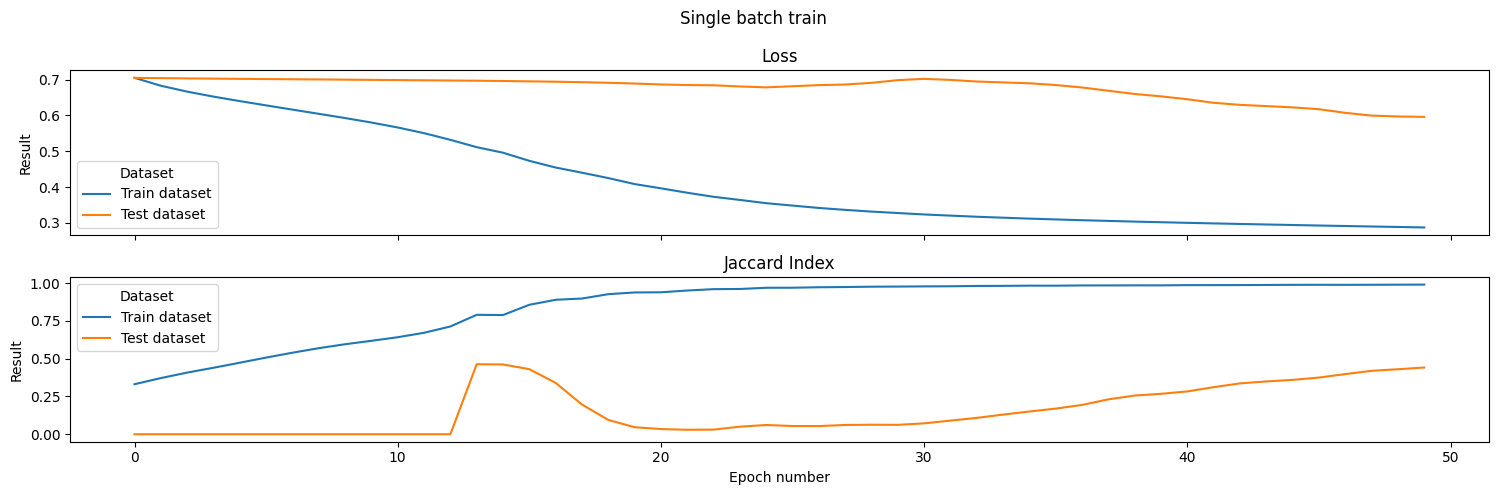

In [17]:
results = pd.read_csv("results-batch.csv")
show_result_plot(results, "Single batch train")

In [18]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0             0             0  Train dataset           Loss  0.704858
1             1             0  Train dataset  Jaccard Index  0.331118
2             2             0   Test dataset           Loss  0.704696
3             3             0   Test dataset  Jaccard Index  0.000000
4             4             1  Train dataset           Loss  0.682779
..          ...           ...            ...            ...       ...
195         195            48   Test dataset  Jaccard Index  0.430245
196         196            49  Train dataset           Loss  0.287461
197         197            49  Train dataset  Jaccard Index  0.990318
198         198            49   Test dataset           Loss  0.595905
199         199            49   Test dataset  Jaccard Index  0.441501

[200 rows x 5 columns]

Train dataset result
Test dataset result


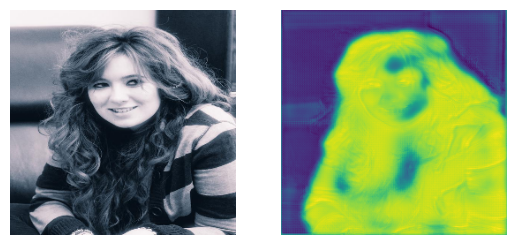

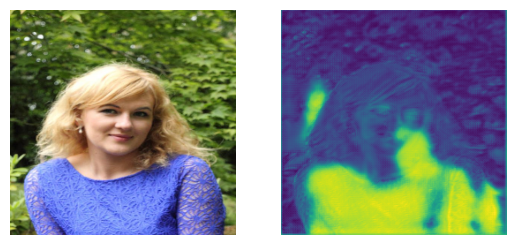

In [19]:
net.eval()

print("Train dataset result")
train_img, mask = train_dataset[0]
train_mask = net(train_img.cuda().unsqueeze(0))[0].cpu()
show_selfie(train_img, nn.functional.sigmoid(train_mask))

print("Test dataset result")
test_img, mask = test_dataset[0]
test_mask = net(test_img.cuda().unsqueeze(0))[0].cpu() 
show_selfie(test_img, nn.functional.sigmoid(test_mask))

Видим, что результат обучающей выборки лучше результата тестовой. При возрастании числа шагов обучения снижается Loss и возрастает Jaccard Index.

# Обучение на всём Train

Выполним обучение на всей Train выборке. В качестве размера батча возьмём число 16.

In [20]:
batch_size = 16
epoch_number = 15 # Google Colab limits accounts for a big computations
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Обучим модель на всей выборке. Возьмём для теста 15 эпох.

In [21]:
from torch.utils.data.datapipes.datapipe import UNTRACABLE_DATAFRAME_PIPES
net = UNET(3, 16, 1)
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

train_model(net, optimizer, train_loader, test_loader, epoch_number).to_csv("results.csv")

100%|██████████| 19/19 [00:03<00:00,  5.00it/s]


Построим график результатов обучения модели на всей выборке:

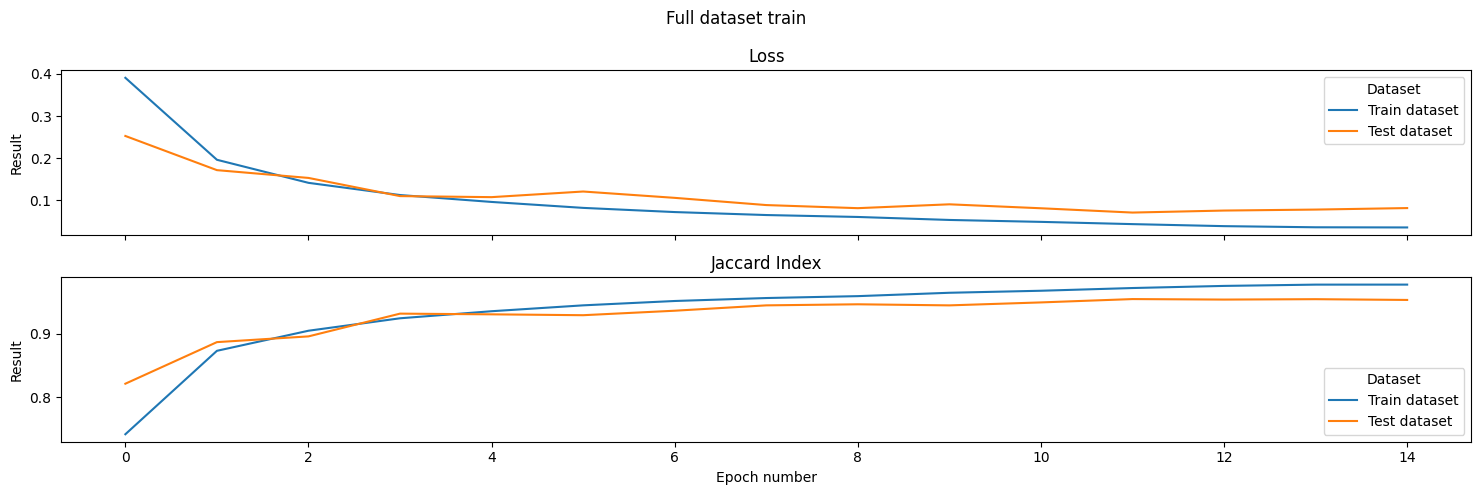

In [22]:
results = pd.read_csv("results.csv")
show_result_plot(results, "Full dataset train")

Из графика видим, что с увеличением числа шагов уменьшается Loss и увеличчивается Jaccard Index.

Выведем полученные результаты как таблицу:

In [23]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.390581
1            1             0  Train dataset  Jaccard Index  0.741876
2            2             0   Test dataset           Loss  0.252742
3            3             0   Test dataset  Jaccard Index  0.821529
4            4             1  Train dataset           Loss  0.196298
5            5             1  Train dataset  Jaccard Index  0.873366
6            6             1   Test dataset           Loss  0.171734
7            7             1   Test dataset  Jaccard Index  0.887067
8            8             2  Train dataset           Loss  0.141642
9            9             2  Train dataset  Jaccard Index  0.905023
10          10             2   Test dataset           Loss  0.153278
11          11             2   Test dataset  Jaccard Index  0.896106
12          12             3  Train dataset           Loss  0.112714
13          13             3  Train dataset  Jaccard Index  0.924642
14          14             3   Test dataset           Loss  0.110183
15          15             3   Test dataset  Jaccard Index  0.931975
16          16             4  Train dataset           Loss  0.096368
17          17             4  Train dataset  Jaccard Index  0.935774
18          18             4   Test dataset           Loss  0.107735
19          19             4   Test dataset  Jaccard Index  0.930864
20          20             5  Train dataset           Loss  0.082279
21          21             5  Train dataset  Jaccard Index  0.945036
22          22             5   Test dataset           Loss  0.121080
23          23             5   Test dataset  Jaccard Index  0.929492
24          24             6  Train dataset           Loss  0.072369
25          25             6  Train dataset  Jaccard Index  0.951893
26          26             6   Test dataset           Loss  0.106045
27          27             6   Test dataset  Jaccard Index  0.936562
28          28             7  Train dataset           Loss  0.065315
29          29             7  Train dataset  Jaccard Index  0.956561
30          30             7   Test dataset           Loss  0.088946
31          31             7   Test dataset  Jaccard Index  0.945007
32          32             8  Train dataset           Loss  0.060759
33          33             8  Train dataset  Jaccard Index  0.959545
34          34             8   Test dataset           Loss  0.081603
35          35             8   Test dataset  Jaccard Index  0.946694
36          36             9  Train dataset           Loss  0.053671
37          37             9  Train dataset  Jaccard Index  0.964857
38          38             9   Test dataset           Loss  0.090735
39          39             9   Test dataset  Jaccard Index  0.944988
40          40            10  Train dataset           Loss  0.049114
41          41            10  Train dataset  Jaccard Index  0.968040
42          42            10   Test dataset           Loss  0.081368
43          43            10   Test dataset  Jaccard Index  0.949655
44          44            11  Train dataset           Loss  0.043796
45          45            11  Train dataset  Jaccard Index  0.972327
46          46            11   Test dataset           Loss  0.071177
47          47            11   Test dataset  Jaccard Index  0.954924
48          48            12  Train dataset           Loss  0.038992
49          49            12  Train dataset  Jaccard Index  0.975668
50          50            12   Test dataset           Loss  0.075952
51          51            12   Test dataset  Jaccard Index  0.954129
52          52            13  Train dataset           Loss  0.036287
53          53            13  Train dataset  Jaccard Index  0.977694
54          54            13   Test dataset           Loss  0.078263
55          55            13   Test dataset  Jaccard Index  0.954749
56          56            14  Train dataset           Loss  0.035900
57

Реализуем функцию отбора самых плохих предсказаний и найдем 5 худших результатов:

In [24]:
def show_worst_predictions(net, number):
    predictions = []
    for i, data in tqdm(enumerate(test_loader, 0)):
        x = data[0]
        y = data[1]
        pred = net(x.cuda())
        metric = calculate_jaccard_metric(pred, y).item()
        predictions.append((metric, i))

    worst_predictions = sorted(predictions)[:number]
    for _, idx in worst_predictions:
        image, mask = test_dataset[idx]
        pred = net(image.cuda().unsqueeze(0))
        show_selfie(image, pred[0].cpu())

19it [00:04,  4.07it/s]


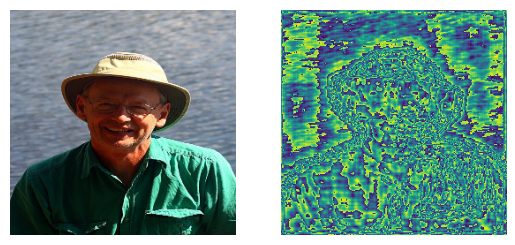

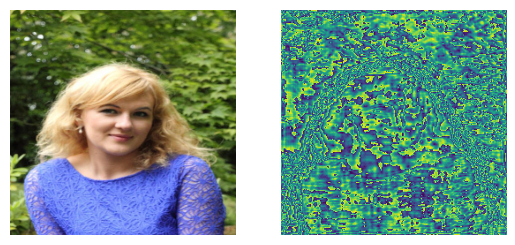

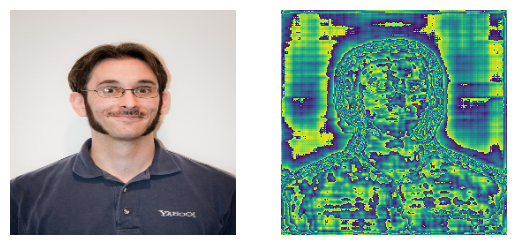

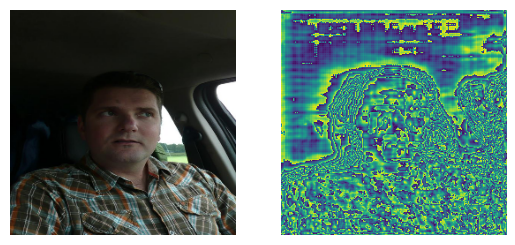

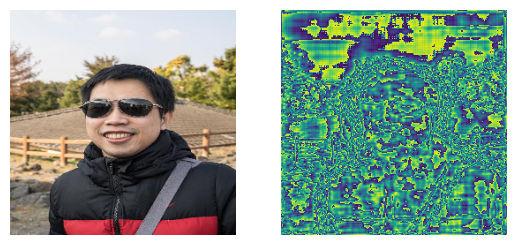

In [25]:
show_worst_predictions(net, 5)

Результаты не очень, конечно, но проглядывается контур человека, что уже ничего)

# Аугментация

Попробуем улучшить качество предсказаний с помощью аугментации. Модифицируем существующие данные для увеличения выборки.

Применим отражение по горизонтали (horizontal flip) и изменение цвета изображения (color jitter):

In [26]:
import copy
from torchvision import transforms

transformations = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=.5, hue=.3)
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = transformations

train_dataset_extended = torch.utils.data.ConcatDataset(
    [train_dataset_augmented, copy.copy(train_dataset)]
)

train_loader_extended = torch.utils.data.DataLoader(train_dataset_extended, batch_size=batch_size)

(-0.5, 255.5, 255.5, -0.5)

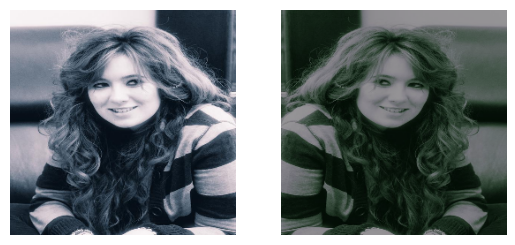

In [27]:
img_train, mask = train_dataset[0]
img_aug, mask = train_dataset_augmented[0]

_, (ax_l, ax_r) = plt.subplots(ncols=2)
ax_l.imshow(functional.to_pil_image(img_train))
ax_l.axis("off")
ax_r.imshow(functional.to_pil_image(img_aug))
ax_r.axis("off")

Дообучим прошлую модель на расширенных данных:

In [28]:
train_model(net, optimizer, train_loader_extended, test_loader, epoch_number).to_csv("results-augmented.csv")

100%|██████████| 19/19 [00:04<00:00,  4.59it/s]


Видим, что время обучения утроилось. Построим график с результатами:

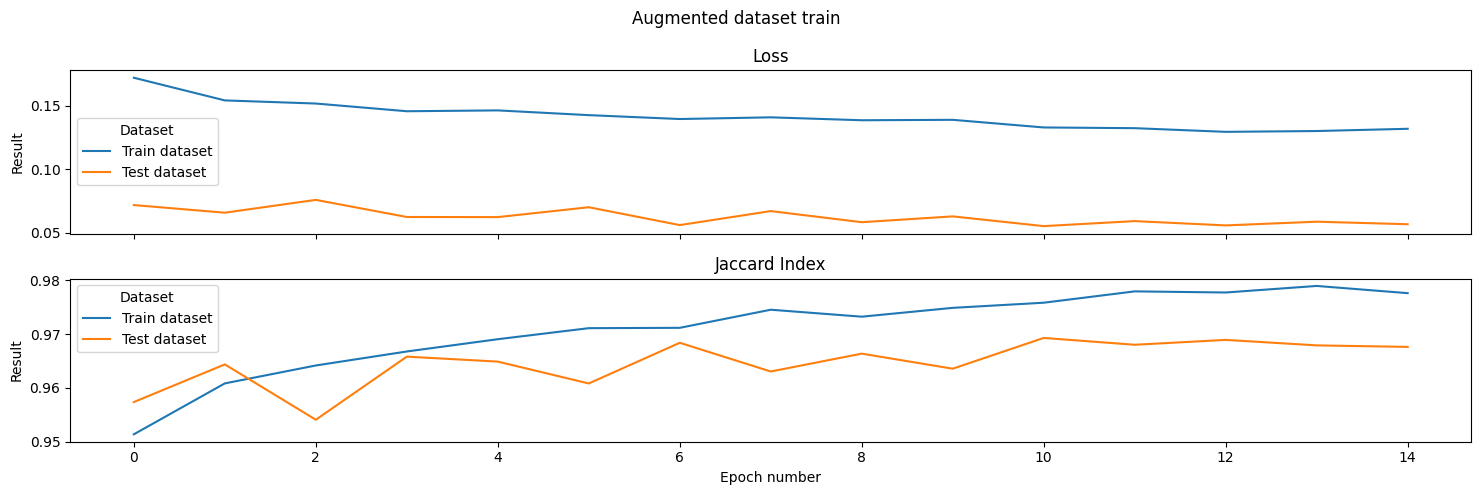

In [29]:
results = pd.read_csv("results-augmented.csv")
show_result_plot(results, "Augmented dataset train")

Видим на графике, что Loss для тестовой выборки уменьшился, а Jaccard Index увеличился.

Выведем таблицу значений:

In [30]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.172236
1            1             0  Train dataset  Jaccard Index  0.951361
2            2             0   Test dataset           Loss  0.071827
3            3             0   Test dataset  Jaccard Index  0.957361
4            4             1  Train dataset           Loss  0.154369
5            5             1  Train dataset  Jaccard Index  0.960836
6            6             1   Test dataset           Loss  0.065818
7            7             1   Test dataset  Jaccard Index  0.964375
8            8             2  Train dataset           Loss  0.151903
9            9             2  Train dataset  Jaccard Index  0.964171
10          10             2   Test dataset           Loss  0.075923
11          11             2   Test dataset  Jaccard Index  0.954071
12          12             3  Train dataset           Loss  0.145827
13          13             3  Train dataset  Jaccard Index  0.966775
14          14             3   Test dataset           Loss  0.062427
15          15             3   Test dataset  Jaccard Index  0.965816
16          16             4  Train dataset           Loss  0.146489
17          17             4  Train dataset  Jaccard Index  0.969062
18          18             4   Test dataset           Loss  0.062331
19          19             4   Test dataset  Jaccard Index  0.964893
20          20             5  Train dataset           Loss  0.142749
21          21             5  Train dataset  Jaccard Index  0.971115
22          22             5   Test dataset           Loss  0.070120
23          23             5   Test dataset  Jaccard Index  0.960825
24          24             6  Train dataset           Loss  0.139687
25          25             6  Train dataset  Jaccard Index  0.971180
26          26             6   Test dataset           Loss  0.056036
27          27             6   Test dataset  Jaccard Index  0.968394
28          28             7  Train dataset           Loss  0.141023
29          29             7  Train dataset  Jaccard Index  0.974549
30          30             7   Test dataset           Loss  0.067080
31          31             7   Test dataset  Jaccard Index  0.963052
32          32             8  Train dataset           Loss  0.138721
33          33             8  Train dataset  Jaccard Index  0.973253
34          34             8   Test dataset           Loss  0.058324
35          35             8   Test dataset  Jaccard Index  0.966372
36          36             9  Train dataset           Loss  0.139055
37          37             9  Train dataset  Jaccard Index  0.974897
38          38             9   Test dataset           Loss  0.062899
39          39             9   Test dataset  Jaccard Index  0.963573
40          40            10  Train dataset           Loss  0.133039
41          41            10  Train dataset  Jaccard Index  0.975852
42          42            10   Test dataset           Loss  0.055229
43          43            10   Test dataset  Jaccard Index  0.969295
44          44            11  Train dataset           Loss  0.132469
45          45            11  Train dataset  Jaccard Index  0.977964
46          46            11   Test dataset           Loss  0.059180
47          47            11   Test dataset  Jaccard Index  0.968028
48          48            12  Train dataset           Loss  0.129577
49          49            12  Train dataset  Jaccard Index  0.977755
50          50            12   Test dataset           Loss  0.055793
51          51            12   Test dataset  Jaccard Index  0.968933
52          52            13  Train dataset           Loss  0.130219
53          53            13  Train dataset  Jaccard Index  0.978975
54          54            13   Test dataset           Loss  0.058718
55          55            13   Test dataset  Jaccard Index  0.967911
56          56            14  Train dataset           Loss  0.131980
57

Посмотрим на 5 худших предсказаний:

19it [00:05,  3.27it/s]


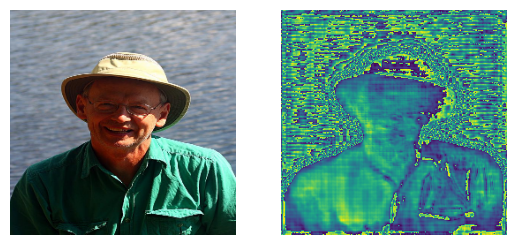

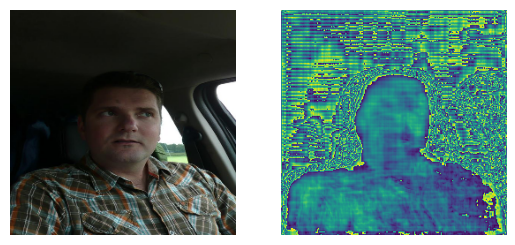

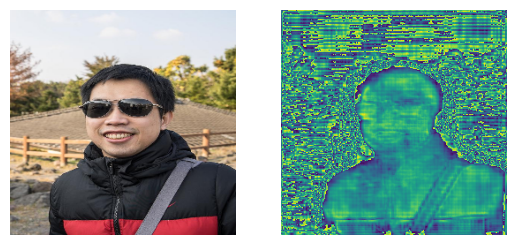

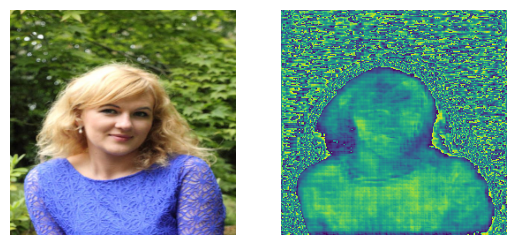

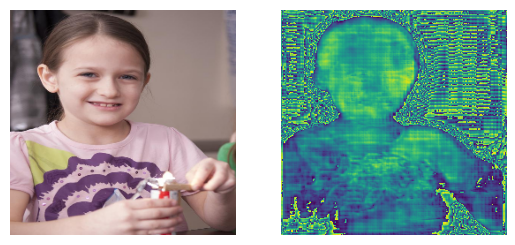

In [31]:
show_worst_predictions(net, 5)

Также можно заметить, что на худших предсказаниях при аугментированном датасете можно хорошо раглядеть контур человека. Результат визуально значительно лучше, чем до аугментации.

# Гиперпараметры

Попробуем улучшить качество предсказаний с помощью подбора гиперпараметров. Попробуем разные значения n_down:

In [32]:
def train_and_save_to_csv(n_down, train_loader, test_loader):
    net = UNET(3, 16, 1, n_down=n_down).cuda()
    optimizer = torch.optim.Adam(net.parameters())

    train_model(net, optimizer, train_loader, test_loader, epoch_number).to_csv(f"results-hyperparam-{n_down}.csv")

n_down_parameters = [2, 4, 8]
for n_down in n_down_parameters:
    print(f"Training net with {n_down} n_down")
    train_and_save_to_csv(n_down, train_loader, test_loader)

Training net with 2 n_down


100%|██████████| 19/19 [00:04<00:00,  3.99it/s]


Training net with 4 n_down


100%|██████████| 19/19 [00:03<00:00,  4.89it/s]


Training net with 8 n_down


100%|██████████| 19/19 [00:04<00:00,  3.97it/s]


Посмотрим график результата для n_down = 2:

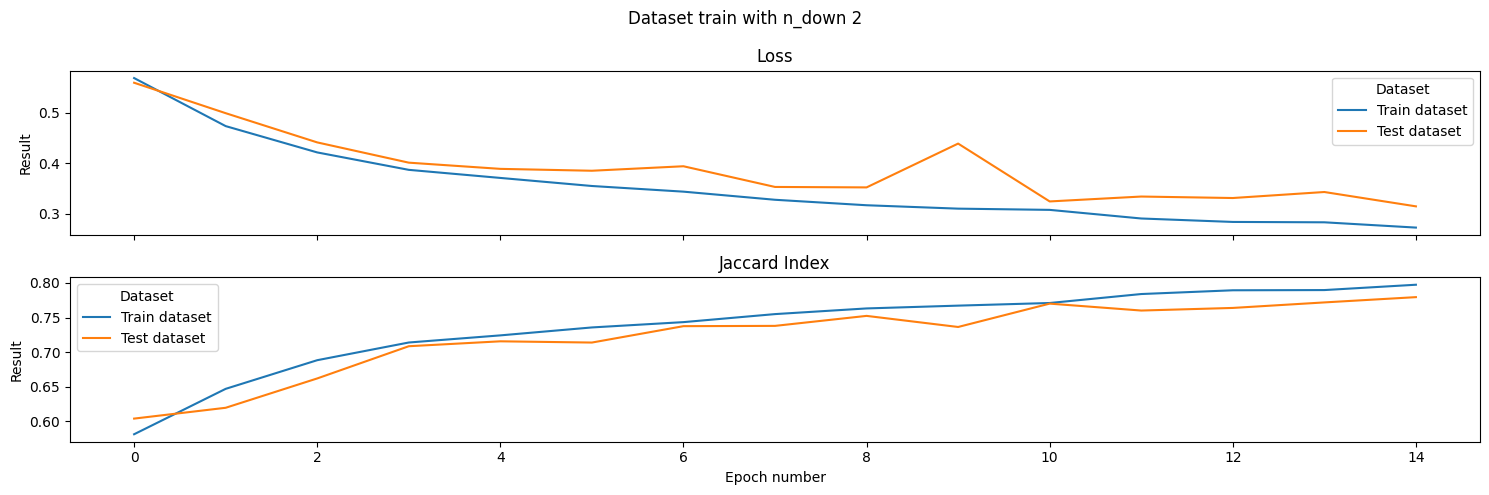

In [33]:
results = pd.read_csv("results-hyperparam-2.csv")
show_result_plot(results, "Dataset train with n_down 2")

In [34]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.568509
1            1             0  Train dataset  Jaccard Index  0.581053
2            2             0   Test dataset           Loss  0.559279
3            3             0   Test dataset  Jaccard Index  0.603701
4            4             1  Train dataset           Loss  0.473490
5            5             1  Train dataset  Jaccard Index  0.646761
6            6             1   Test dataset           Loss  0.499065
7            7             1   Test dataset  Jaccard Index  0.619363
8            8             2  Train dataset           Loss  0.421437
9            9             2  Train dataset  Jaccard Index  0.688225
10          10             2   Test dataset           Loss  0.441252
11          11             2   Test dataset  Jaccard Index  0.661823
12          12             3  Train dataset           Loss  0.386971
13          13             3  Train dataset  Jaccard Index  0.713831
14          14             3   Test dataset           Loss  0.401187
15          15             3   Test dataset  Jaccard Index  0.708448
16          16             4  Train dataset           Loss  0.370981
17          17             4  Train dataset  Jaccard Index  0.724144
18          18             4   Test dataset           Loss  0.388914
19          19             4   Test dataset  Jaccard Index  0.715556
20          20             5  Train dataset           Loss  0.355023
21          21             5  Train dataset  Jaccard Index  0.735632
22          22             5   Test dataset           Loss  0.385196
23          23             5   Test dataset  Jaccard Index  0.713763
24          24             6  Train dataset           Loss  0.343833
25          25             6  Train dataset  Jaccard Index  0.743325
26          26             6   Test dataset           Loss  0.394081
27          27             6   Test dataset  Jaccard Index  0.737485
28          28             7  Train dataset           Loss  0.327773
29          29             7  Train dataset  Jaccard Index  0.754940
30          30             7   Test dataset           Loss  0.353139
31          31             7   Test dataset  Jaccard Index  0.737895
32          32             8  Train dataset           Loss  0.316945
33          33             8  Train dataset  Jaccard Index  0.763143
34          34             8   Test dataset           Loss  0.352251
35          35             8   Test dataset  Jaccard Index  0.752355
36          36             9  Train dataset           Loss  0.310219
37          37             9  Train dataset  Jaccard Index  0.767198
38          38             9   Test dataset           Loss  0.438918
39          39             9   Test dataset  Jaccard Index  0.736301
40          40            10  Train dataset           Loss  0.307792
41          41            10  Train dataset  Jaccard Index  0.771001
42          42            10   Test dataset           Loss  0.324479
43          43            10   Test dataset  Jaccard Index  0.770100
44          44            11  Train dataset           Loss  0.290742
45          45            11  Train dataset  Jaccard Index  0.783979
46          46            11   Test dataset           Loss  0.334162
47          47            11   Test dataset  Jaccard Index  0.760088
48          48            12  Train dataset           Loss  0.283934
49          49            12  Train dataset  Jaccard Index  0.789413
50          50            12   Test dataset           Loss  0.331242
51          51            12   Test dataset  Jaccard Index  0.763867
52          52            13  Train dataset           Loss  0.283198
53          53            13  Train dataset  Jaccard Index  0.789721
54          54            13   Test dataset           Loss  0.343126
55          55            13   Test dataset  Jaccard Index  0.771853
56          56            14  Train dataset           Loss  0.272751
57

Посмотрим график результата для n_down = 4:

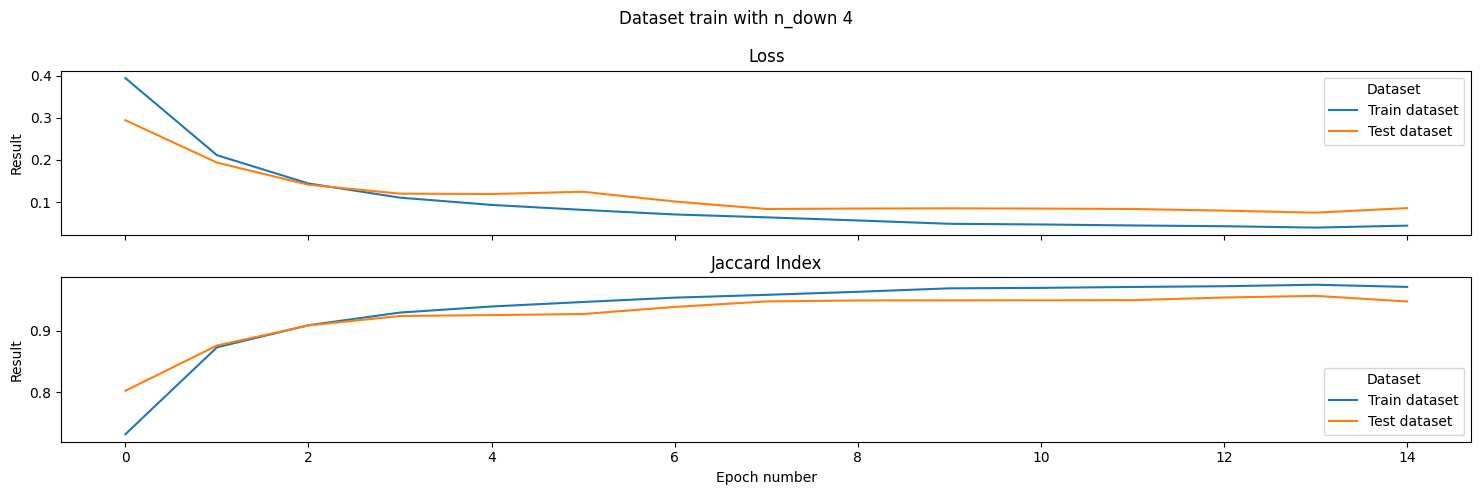

In [35]:
results = pd.read_csv("results-hyperparam-4.csv")
show_result_plot(results, "Dataset train with n_down 4")

In [36]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.394536
1            1             0  Train dataset  Jaccard Index  0.730871
2            2             0   Test dataset           Loss  0.294363
3            3             0   Test dataset  Jaccard Index  0.801995
4            4             1  Train dataset           Loss  0.211357
5            5             1  Train dataset  Jaccard Index  0.873074
6            6             1   Test dataset           Loss  0.193786
7            7             1   Test dataset  Jaccard Index  0.876094
8            8             2  Train dataset           Loss  0.144164
9            9             2  Train dataset  Jaccard Index  0.909279
10          10             2   Test dataset           Loss  0.141116
11          11             2   Test dataset  Jaccard Index  0.908914
12          12             3  Train dataset           Loss  0.110509
13          13             3  Train dataset  Jaccard Index  0.930008
14          14             3   Test dataset           Loss  0.119927
15          15             3   Test dataset  Jaccard Index  0.924400
16          16             4  Train dataset           Loss  0.093254
17          17             4  Train dataset  Jaccard Index  0.939964
18          18             4   Test dataset           Loss  0.119194
19          19             4   Test dataset  Jaccard Index  0.925853
20          20             5  Train dataset           Loss  0.081412
21          21             5  Train dataset  Jaccard Index  0.947304
22          22             5   Test dataset           Loss  0.124499
23          23             5   Test dataset  Jaccard Index  0.927613
24          24             6  Train dataset           Loss  0.070600
25          25             6  Train dataset  Jaccard Index  0.954393
26          26             6   Test dataset           Loss  0.101322
27          27             6   Test dataset  Jaccard Index  0.939190
28          28             7  Train dataset           Loss  0.063745
29          29             7  Train dataset  Jaccard Index  0.959000
30          30             7   Test dataset           Loss  0.083655
31          31             7   Test dataset  Jaccard Index  0.948197
32          32             8  Train dataset           Loss  0.056340
33          33             8  Train dataset  Jaccard Index  0.963999
34          34             8   Test dataset           Loss  0.084602
35          35             8   Test dataset  Jaccard Index  0.949812
36          36             9  Train dataset           Loss  0.048406
37          37             9  Train dataset  Jaccard Index  0.969652
38          38             9   Test dataset           Loss  0.085126
39          39             9   Test dataset  Jaccard Index  0.949997
40          40            10  Train dataset           Loss  0.046798
41          41            10  Train dataset  Jaccard Index  0.970418
42          42            10   Test dataset           Loss  0.084544
43          43            10   Test dataset  Jaccard Index  0.950063
44          44            11  Train dataset           Loss  0.044437
45          45            11  Train dataset  Jaccard Index  0.971909
46          46            11   Test dataset           Loss  0.083597
47          47            11   Test dataset  Jaccard Index  0.950346
48          48            12  Train dataset           Loss  0.042629
49          49            12  Train dataset  Jaccard Index  0.973113
50          50            12   Test dataset           Loss  0.079675
51          51            12   Test dataset  Jaccard Index  0.954604
52          52            13  Train dataset           Loss  0.039394
53          53            13  Train dataset  Jaccard Index  0.975547
54          54            13   Test dataset           Loss  0.074907
55          55            13   Test dataset  Jaccard Index  0.957336
56          56            14  Train dataset           Loss  0.044023
57

Посмотрим график результата для n_down = 8:

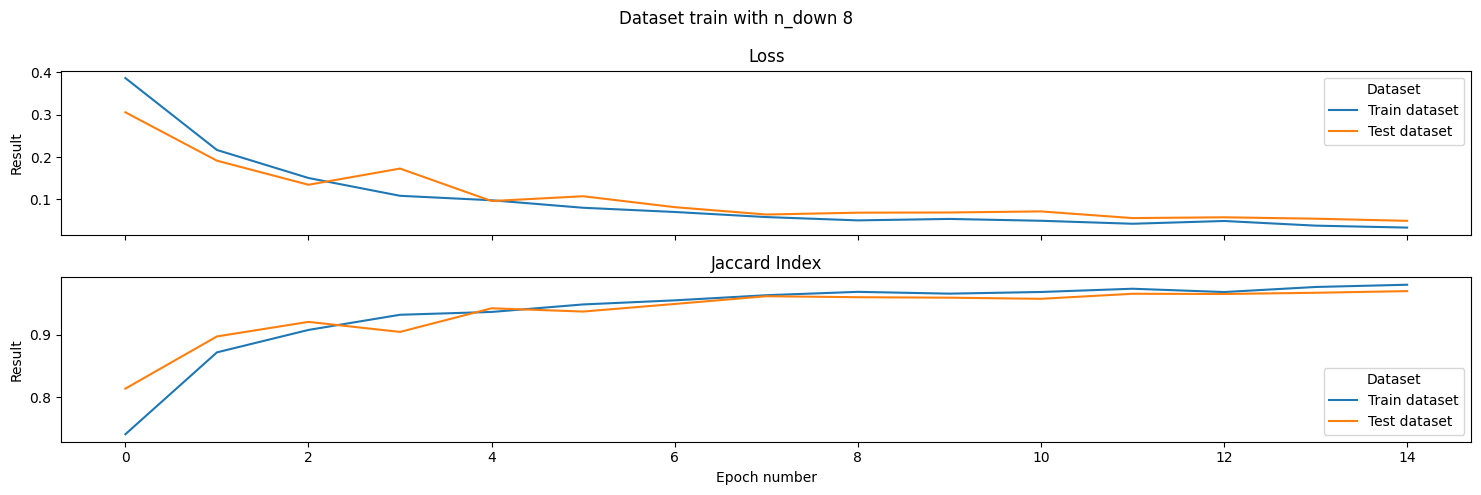

In [37]:
results = pd.read_csv("results-hyperparam-8.csv")
show_result_plot(results, "Dataset train with n_down 8")

In [38]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.386525
1            1             0  Train dataset  Jaccard Index  0.740611
2            2             0   Test dataset           Loss  0.305653
3            3             0   Test dataset  Jaccard Index  0.813671
4            4             1  Train dataset           Loss  0.216620
5            5             1  Train dataset  Jaccard Index  0.871745
6            6             1   Test dataset           Loss  0.191313
7            7             1   Test dataset  Jaccard Index  0.897238
8            8             2  Train dataset           Loss  0.150397
9            9             2  Train dataset  Jaccard Index  0.907690
10          10             2   Test dataset           Loss  0.134409
11          11             2   Test dataset  Jaccard Index  0.920574
12          12             3  Train dataset           Loss  0.108328
13          13             3  Train dataset  Jaccard Index  0.931963
14          14             3   Test dataset           Loss  0.172678
15          15             3   Test dataset  Jaccard Index  0.904490
16          16             4  Train dataset           Loss  0.097787
17          17             4  Train dataset  Jaccard Index  0.936479
18          18             4   Test dataset           Loss  0.095970
19          19             4   Test dataset  Jaccard Index  0.942336
20          20             5  Train dataset           Loss  0.080038
21          21             5  Train dataset  Jaccard Index  0.948505
22          22             5   Test dataset           Loss  0.107263
23          23             5   Test dataset  Jaccard Index  0.937113
24          24             6  Train dataset           Loss  0.070092
25          25             6  Train dataset  Jaccard Index  0.955040
26          26             6   Test dataset           Loss  0.081487
27          27             6   Test dataset  Jaccard Index  0.949264
28          28             7  Train dataset           Loss  0.058069
29          29             7  Train dataset  Jaccard Index  0.963275
30          30             7   Test dataset           Loss  0.064058
31          31             7   Test dataset  Jaccard Index  0.961667
32          32             8  Train dataset           Loss  0.050258
33          33             8  Train dataset  Jaccard Index  0.968661
34          34             8   Test dataset           Loss  0.068430
35          35             8   Test dataset  Jaccard Index  0.960073
36          36             9  Train dataset           Loss  0.053648
37          37             9  Train dataset  Jaccard Index  0.965787
38          38             9   Test dataset           Loss  0.068887
39          39             9   Test dataset  Jaccard Index  0.959327
40          40            10  Train dataset           Loss  0.049325
41          41            10  Train dataset  Jaccard Index  0.968443
42          42            10   Test dataset           Loss  0.071443
43          43            10   Test dataset  Jaccard Index  0.957510
44          44            11  Train dataset           Loss  0.042270
45          45            11  Train dataset  Jaccard Index  0.973651
46          46            11   Test dataset           Loss  0.055676
47          47            11   Test dataset  Jaccard Index  0.965588
48          48            12  Train dataset           Loss  0.048799
49          49            12  Train dataset  Jaccard Index  0.968349
50          50            12   Test dataset           Loss  0.057517
51          51            12   Test dataset  Jaccard Index  0.965233
52          52            13  Train dataset           Loss  0.037809
53          53            13  Train dataset  Jaccard Index  0.976464
54          54            13   Test dataset           Loss  0.054222
55          55            13   Test dataset  Jaccard Index  0.967187
56          56            14  Train dataset           Loss  0.033208
57

С увеличением n_down увеличивается время обучения. Модель с параметром n_down оказалось самой быстробучаемой. Самая медленная скорость обучения у модели с n_down = 8.

Наилучшие Loss и Jaccard Index оказались у модели с n_down = 8.



Посмотрим на худшие предсказания этой модели:

19it [00:04,  4.41it/s]


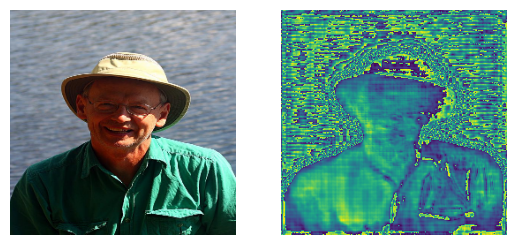

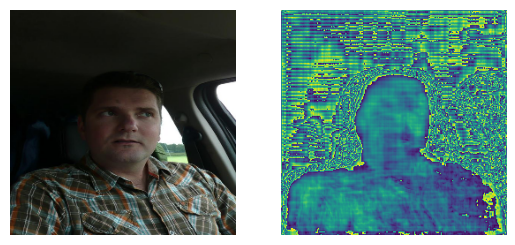

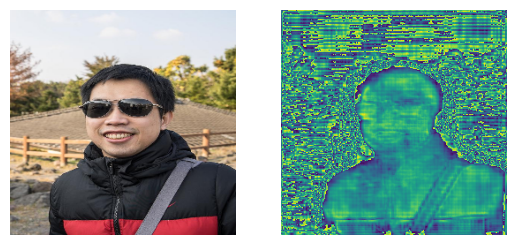

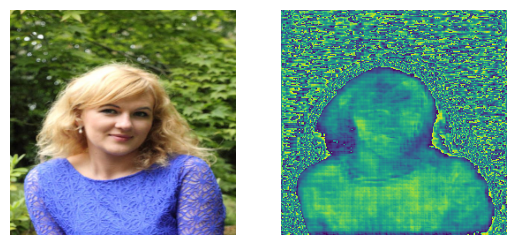

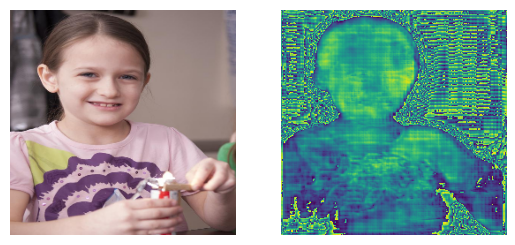

In [39]:
show_worst_predictions(net, 5)

Видим, что удалось выделить контур фигуры человека.

# Test Time аугментации

Реализуем Test Time аугментацию, используя horizontal flip:

In [40]:
class SegmentationTTAWrapper(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net


    def horizontal_flip(self, image):
        # Use p = 1 to flip image.
        transformation = transforms.RandomHorizontalFlip(p=1)
        return transformation(image)
    

    def forward(self, image):
        flipped_image = self.horizontal_flip(image)
        concatenated_image = torch.cat([image, flipped_image])
        prediction = self.net(concatenated_image)

        result, augmented_result = prediction.chunk(2)
        flipped_augmented_result = self.horizontal_flip(augmented_result)

        return torch.mean(torch.stack([result, flipped_augmented_result]), dim=0)

Обучим TTA модель:

In [41]:
net = UNET(3, 8, 1).cuda()
tta_net = SegmentationTTAWrapper(net).cuda()

optimizer = torch.optim.Adam(tta_net.parameters())
train_model(tta_net, optimizer, train_loader, test_loader, epoch_number).to_csv(f"results-tta.csv")

100%|██████████| 19/19 [00:04<00:00,  4.74it/s]


Посмотрим график результата для TTA:

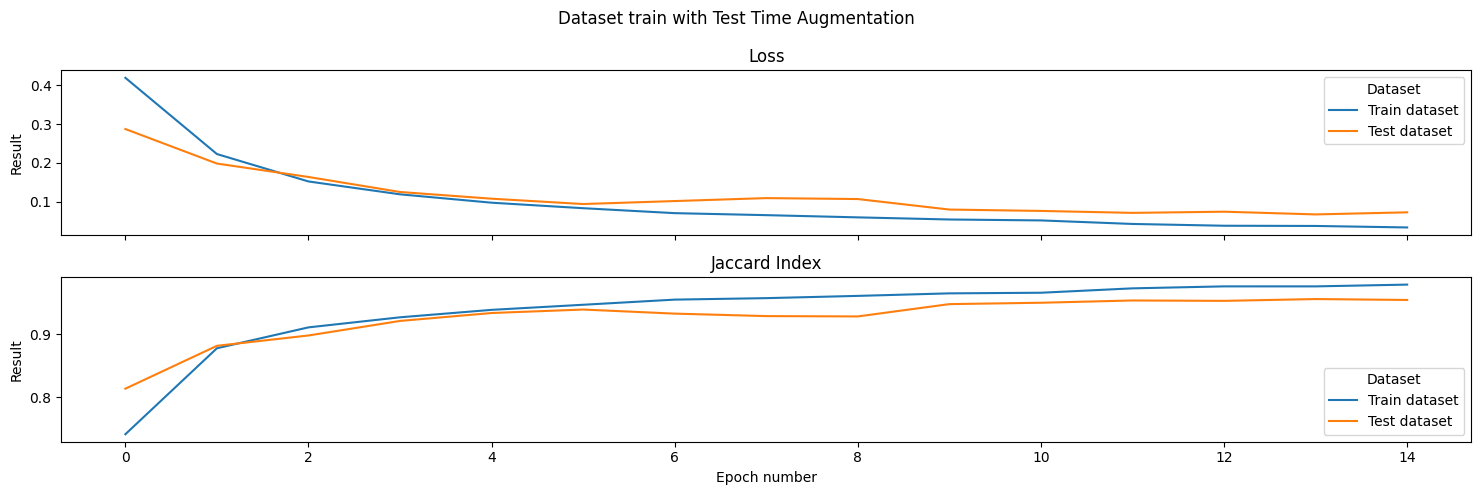

In [42]:
results = pd.read_csv("results-tta.csv")
show_result_plot(results, "Dataset train with Test Time Augmentation")

In [43]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.419342
1            1             0  Train dataset  Jaccard Index  0.740908
2            2             0   Test dataset           Loss  0.287467
3            3             0   Test dataset  Jaccard Index  0.813555
4            4             1  Train dataset           Loss  0.223049
5            5             1  Train dataset  Jaccard Index  0.878017
6            6             1   Test dataset           Loss  0.198585
7            7             1   Test dataset  Jaccard Index  0.881904
8            8             2  Train dataset           Loss  0.152457
9            9             2  Train dataset  Jaccard Index  0.911318
10          10             2   Test dataset           Loss  0.164016
11          11             2   Test dataset  Jaccard Index  0.898398
12          12             3  Train dataset           Loss  0.119328
13          13             3  Train dataset  Jaccard Index  0.927372
14          14             3   Test dataset           Loss  0.125340
15          15             3   Test dataset  Jaccard Index  0.921585
16          16             4  Train dataset           Loss  0.097771
17          17             4  Train dataset  Jaccard Index  0.939251
18          18             4   Test dataset           Loss  0.108071
19          19             4   Test dataset  Jaccard Index  0.934227
20          20             5  Train dataset           Loss  0.083577
21          21             5  Train dataset  Jaccard Index  0.947373
22          22             5   Test dataset           Loss  0.094328
23          23             5   Test dataset  Jaccard Index  0.939740
24          24             6  Train dataset           Loss  0.070854
25          25             6  Train dataset  Jaccard Index  0.955575
26          26             6   Test dataset           Loss  0.101988
27          27             6   Test dataset  Jaccard Index  0.933233
28          28             7  Train dataset           Loss  0.065698
29          29             7  Train dataset  Jaccard Index  0.957928
30          30             7   Test dataset           Loss  0.109603
31          31             7   Test dataset  Jaccard Index  0.929301
32          32             8  Train dataset           Loss  0.059993
33          33             8  Train dataset  Jaccard Index  0.961524
34          34             8   Test dataset           Loss  0.107164
35          35             8   Test dataset  Jaccard Index  0.928765
36          36             9  Train dataset           Loss  0.054520
37          37             9  Train dataset  Jaccard Index  0.965546
38          38             9   Test dataset           Loss  0.080099
39          39             9   Test dataset  Jaccard Index  0.948399
40          40            10  Train dataset           Loss  0.052135
41          41            10  Train dataset  Jaccard Index  0.966538
42          42            10   Test dataset           Loss  0.076583
43          43            10   Test dataset  Jaccard Index  0.950593
44          44            11  Train dataset           Loss  0.043039
45          45            11  Train dataset  Jaccard Index  0.973536
46          46            11   Test dataset           Loss  0.071555
47          47            11   Test dataset  Jaccard Index  0.954211
48          48            12  Train dataset           Loss  0.038432
49          49            12  Train dataset  Jaccard Index  0.976702
50          50            12   Test dataset           Loss  0.074589
51          51            12   Test dataset  Jaccard Index  0.953590
52          52            13  Train dataset           Loss  0.037873
53          53            13  Train dataset  Jaccard Index  0.976683
54          54            13   Test dataset           Loss  0.067606
55          55            13   Test dataset  Jaccard Index  0.956479
56          56            14  Train dataset           Loss  0.034032
57

Из графика и результатов видим, что по сравнению с обычной UNET моделью значение Loss стало меньше, а Jaccard Index больше.

Было:
- Loss = 0.098;
- Jaccard Index = 0.954.

Стало:
- Loss = 0.068;
- Jaccard Index = 0.956.

# Изменение архитектуры

Попробуем улучшить качество, изменив архитектуру решения. Возьмём архитектуру, описанную из Pytorch-UNet: https://github.com/milesial/Pytorch-UNet.

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

  
class UNetNew(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNetNew, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

In [45]:
net = UNetNew(3, 1).cuda()
optimizer = torch.optim.Adam(net.parameters())

train_model(net, optimizer, train_loader, test_loader, epoch_number + 5).to_csv("results-architecture.csv")

100%|██████████| 19/19 [00:08<00:00,  2.23it/s]


Построим график результатов обучения с новой архитектурой:

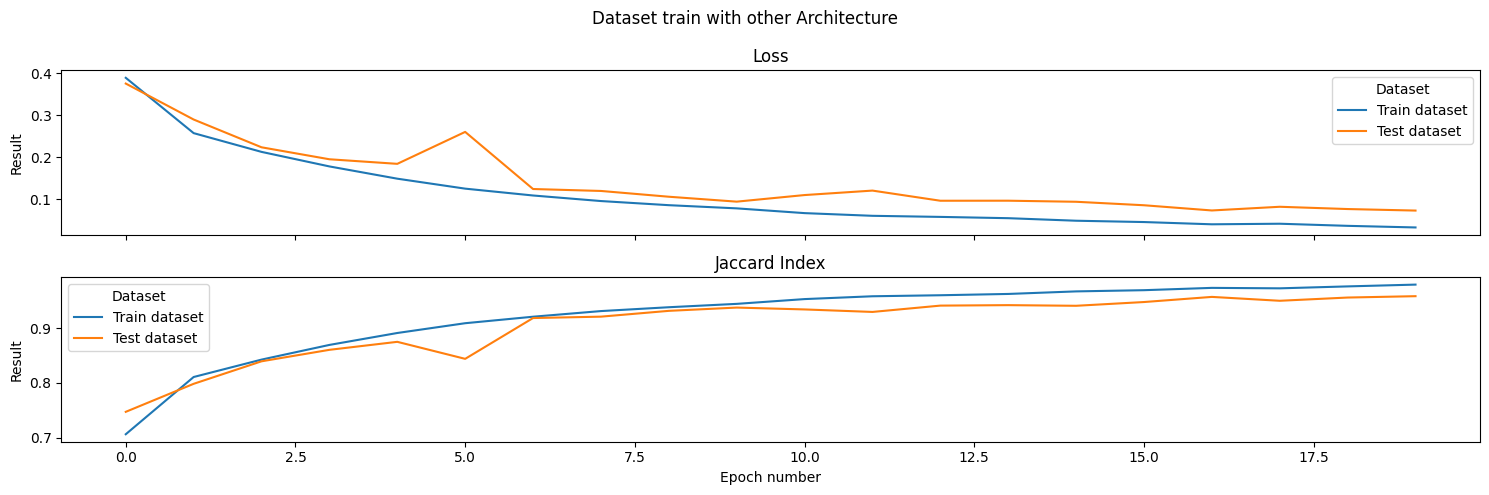

In [46]:
results = pd.read_csv("results-architecture.csv")
show_result_plot(results, "Dataset train with other Architecture")

In [47]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.388939
1            1             0  Train dataset  Jaccard Index  0.705992
2            2             0   Test dataset           Loss  0.375286
3            3             0   Test dataset  Jaccard Index  0.746951
4            4             1  Train dataset           Loss  0.257526
..         ...           ...            ...            ...       ...
75          75            18   Test dataset  Jaccard Index  0.955824
76          76            19  Train dataset           Loss  0.033462
77          77            19  Train dataset  Jaccard Index  0.979460
78          78            19   Test dataset           Loss  0.073564
79          79            19   Test dataset  Jaccard Index  0.958302

[80 rows x 5 columns]

Видим, что результаты получились лучше, чем при исходной архитектуре, но хуже чем с n_down = 8. Обучение проводилось с большим числом шагов. На тестовой выборке получился лучший результат Loss = 0.07, Jaccard Index = 0.958. Скорость обучения медленнее исходной модели.



# Выводы

- Переобучение на одном батче не дало идеального качества на тестовой выборке:
  + Лучшее значение Loss: 0.596;
  + Лучшее значение Jaccard Index: 0.442.
- Аугментация позволяет сильно улучшить качество предсказаний исходной модели.
  + Использование аугментации значительно увеличивает длительность обучения модели -- на тестовых данных длительность обучения возросло в три раза.
  + Лучшее значение Loss: 0.08;
  + Лучшее значение Jaccard Index: 0.955.
- Подбор гиперпараметров позволяят улучшить качество предсказаний исходной модели. На тестовых данных лучшим гиперпараметром оказался n_down = 8.
  + Подбор гиперпараметров увеличивает время обучения модели -- с n_down = 8 обучение выполняется в два раза дольше, чем с n_down = 2.
  + Лучшее значение Loss: 0.05.
  + Лучшее значение Jaccard Index: 0.970.
- Использование Test Time аугментации позволяет улучшить качество предсказаний исходной модели.
  + Использование Test Time аугментации увеличивает время обучения модели -- примерно на 5 секунд для каждого шага.
  + Лучшее значение Loss: 0.07.
  + Лучшее значение Jaccard Index: 0.956.
- Изменение архитектуры влияет на качество предсказаний.
  + В качестве примера была использована реализация из открытых источников;
  + Лучшее значение Loss: 0.07.
  + Лучшее значение Jaccard Index: 0.958.

